In [25]:
library(fpp2)
library(gridExtra)

In [26]:
# 1. 자동차 부품 회사의 월별 판매량과 광고 데이터를 살펴봅시다(데이터 모음 advert)
str(advert)

 Time-Series [1:24, 1:2] from 1 to 24: 25 0 15 10 20 10 5 5 15 15 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "advert" "sales"


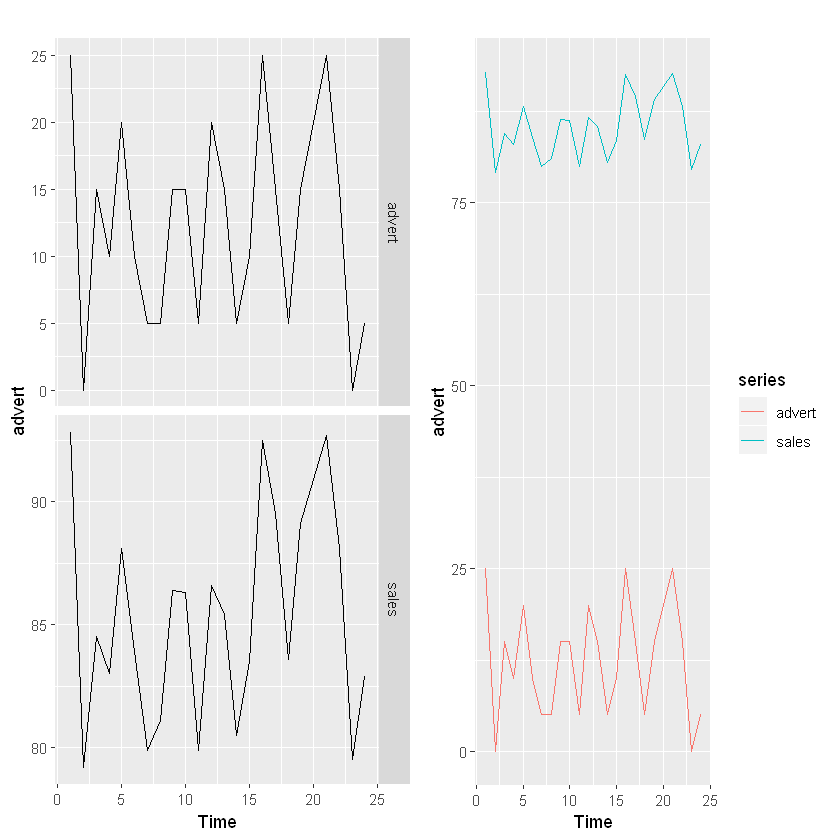

In [27]:
# a. autoplot을 이용하여 데이터를 그래프로 나타내봅시다. facets=TRUE로 두는 것이 왜 유용합니까?

p1 <- autoplot(advert, facets = TRUE)
p2 <- autoplot(advert, facets = FALSE)

grid.arrange(p1, p2,
    layout_matrix = rbind(
        c(1, 2)))

In [28]:
# b. tslm() 함수를 이용하여 표준 회귀 모델  y_t = a + (b * x_t) + η_t 을 맞춰봅시다.
# 여기에서 y_t 는 판매량이고, x_t 는 광고 데이터입니다.

# https://otexts.com/fppkr/regression-intro.html

fit_tslm <- tslm(sales ~ advert, data = advert)
summary(fit_tslm)


Call:
tslm(formula = sales ~ advert, data = advert)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8194 -1.1375 -0.2412  0.9123  2.7519 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 78.73426    0.59735  131.81  < 2e-16 ***
advert       0.53426    0.04098   13.04 7.96e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.506 on 22 degrees of freedom
Multiple R-squared:  0.8854,	Adjusted R-squared:  0.8802 
F-statistic:   170 on 1 and 22 DF,  p-value: 7.955e-12


In [29]:
print(head(advert)) # Frequency = 1 이어서, trend 는 무시해도 되므로 lm 으로 fit.

Time Series:
Start = 1 
End = 6 
Frequency = 1 
  advert sales
1     25  92.8
2      0  79.2
3     15  84.5
4     10  83.0
5     20  88.1
6     10  83.9


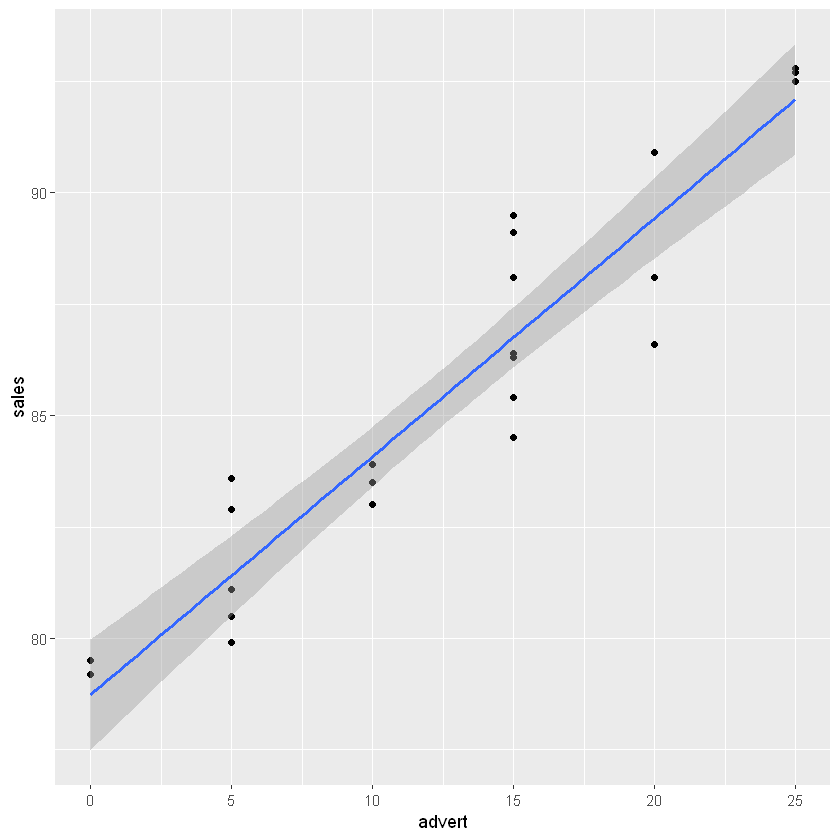

In [30]:
advert %>%
as.data.frame %>%
ggplot(aes(x = advert, y = sales)) +
    geom_point() +
    geom_smooth(method="lm")

In [31]:
# c. 잔차에 유의미한 자기상관이 있다는 것을 증명해봅시다.


	Breusch-Godfrey test for serial correlation of order up to 5

data:  Residuals from Linear regression model
LM test = 12.498, df = 5, p-value = 0.02856


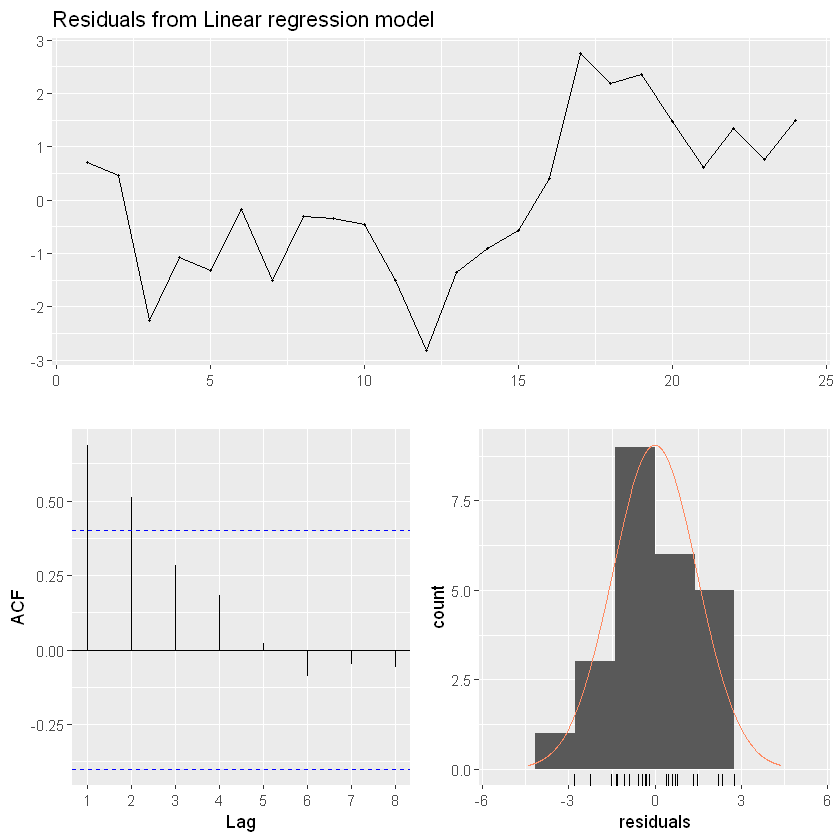

In [32]:
checkresiduals(fit_tslm)

In [33]:
# d. Arima 함수를 사용하는 대신에 아래의 함수를 사용하면 어떤 차이가 있습니까?
fit_Arima <- Arima(advert[,'sales'], xreg = advert[,'advert'], order = c(0, 0, 0))
fit_Arima

Series: advert[, "sales"] 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      intercept    xreg
        78.7343  0.5343
s.e.     0.5719  0.0392

sigma^2 estimated as 2.267:  log likelihood=-42.83
AIC=91.66   AICc=92.86   BIC=95.2


	Ljung-Box test

data:  Residuals from Regression with ARIMA(0,0,0) errors
Q* = 23.683, df = 3, p-value = 2.91e-05

Model df: 2.   Total lags used: 5



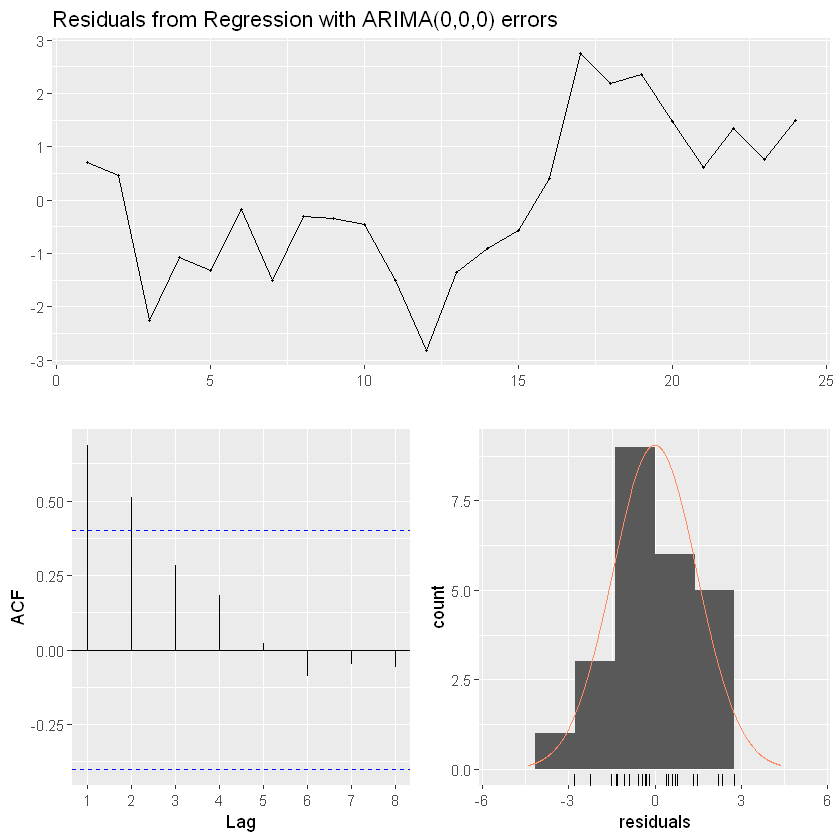

In [34]:
checkresiduals(fit_Arima)

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1]  1.039169e-13  1.271205e-14 -9.325873e-15 -1.265654e-14 -5.773160e-15
 [6] -1.271205e-14  1.154632e-14  1.171285e-14 -9.214851e-15 -9.159340e-15
[11]  1.154632e-14 -5.773160e-15 -9.325873e-15  1.154632e-14 -1.276756e-14
[16] -1.670886e-14 -9.325873e-15  1.154632e-14 -9.325873e-15 -5.773160e-15
[21] -1.676437e-14 -9.325873e-15  8.548717e-15  1.154632e-14


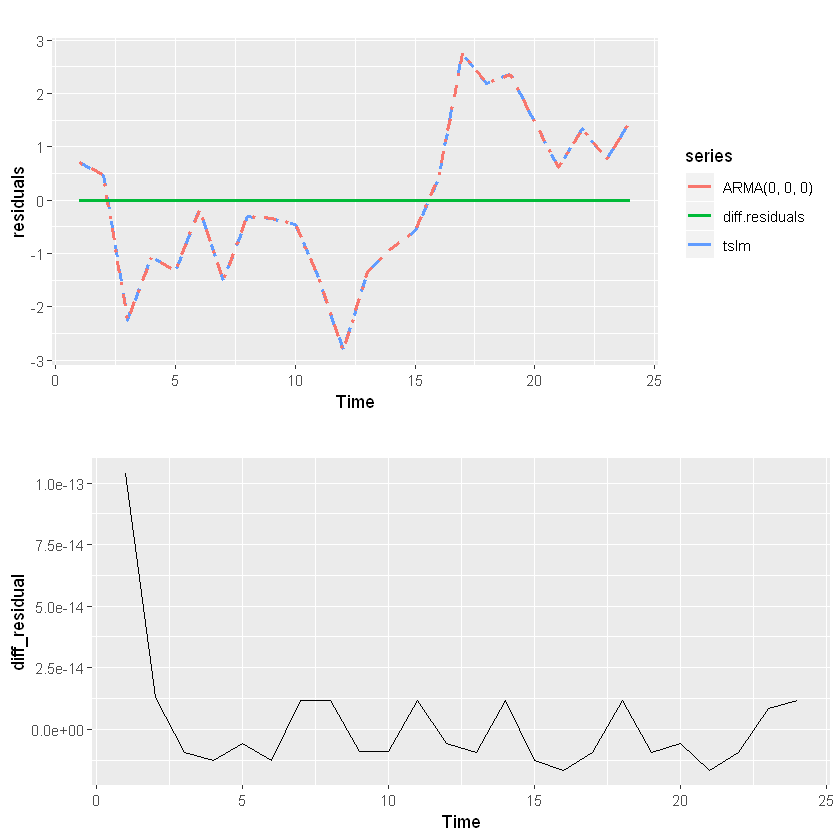

In [55]:
diff_residual <- fit_tslm$residuals - fit_Arima$residuals
print(diff_residual)

p1 <- autoplot(fit_tslm$residuals, series = "tslm", linetype = 'dashed', size = 1) +
    autolayer(fit_Arima$residuals, series = "ARMA(0, 0, 0)", linetype = 'dotdash', size = 1) +
    autolayer(diff_residual, series = "diff.residuals", linetype = 'solid', size = 1) +
    ylab("residuals")

p2 <- autoplot(diff_residual)

grid.arrange(p1, p2,
    layout_matrix = rbind(
        c(1),
        c(2)))

In [36]:
# e. auto.arima()를 이용하여 모델을 다시 맞춰봅시다. 오차 모델이 추정된 매개변수에 얼마나 많은 차이를 만들어냅니까? 
# 오차에 대해 어떤 ARIMA 모델을 골라야합니까?

fit_auto.arima <- auto.arima(advert[, "sales"], xreg = advert[, "advert"])
print('[auto arima]')
fit_auto.arima
print('[Arima 0.0.0]')
fit_Arima
print('[tslm]')
fit_tslm

[1] "[auto arima]"


Series: advert[, "sales"] 
Regression with ARIMA(0,1,0) errors 

Coefficients:
        xreg
      0.5063
s.e.  0.0210

sigma^2 estimated as 1.201:  log likelihood=-34.22
AIC=72.45   AICc=73.05   BIC=74.72

[1] "[Arima 0.0.0]"


Series: advert[, "sales"] 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      intercept    xreg
        78.7343  0.5343
s.e.     0.5719  0.0392

sigma^2 estimated as 2.267:  log likelihood=-42.83
AIC=91.66   AICc=92.86   BIC=95.2

[1] "[tslm]"



Call:
tslm(formula = sales ~ advert, data = advert)

Coefficients:
(Intercept)       advert  
    78.7343       0.5343  



	Ljung-Box test

data:  Residuals from Regression with ARIMA(0,1,0) errors
Q* = 1.5622, df = 4, p-value = 0.8156

Model df: 1.   Total lags used: 5



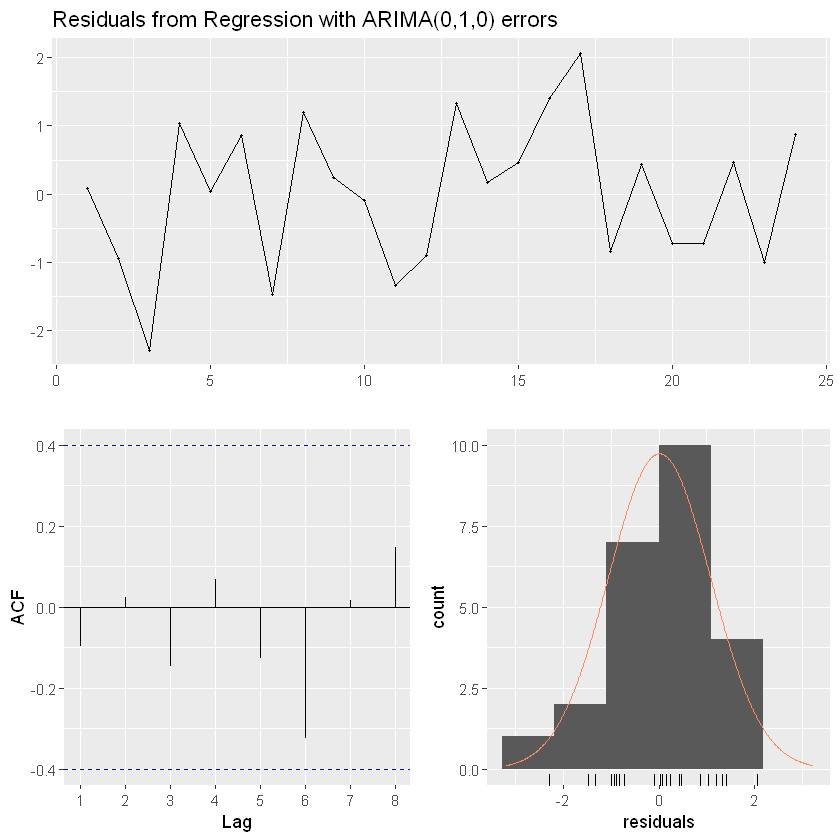

In [37]:
# f. 맞춘 모델의 잔차를 확인해봅시다.
checkresiduals(fit_auto.arima)

In [38]:
accuracy(fit_tslm)
accuracy(fit_Arima)
accuracy(fit_auto.arima)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0,1.441523,1.215355,-0.02765613,1.421018,0.2634605,0.6875239


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-1.776357e-15,1.441523,1.215355,-0.02765613,1.421018,0.2634605,0.6875239


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.01279435,1.049041,0.8745732,-0.00247038,1.032833,0.189587,-0.09614401


Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1]  0.62911795  1.40708689  0.04704416 -2.10858262 -1.35598291 -1.04031339
 [7] -0.03728632 -1.50555556 -0.58468661 -0.34814815 -0.16901709 -1.92425214
[13] -2.67987892 -1.06901709 -1.04512108 -0.99554843  0.68839031  3.03098291
[19]  1.91531339  2.21228632  1.34099003  0.88839031  1.77054843  0.62617521


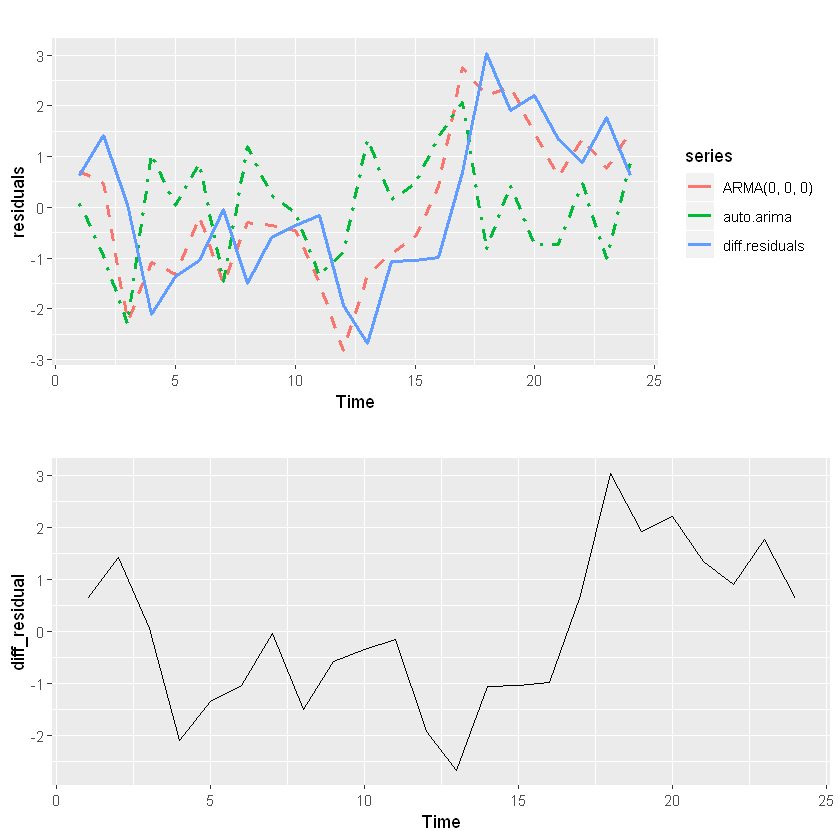

In [57]:
# http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software

diff_residual <- fit_Arima$residuals - fit_auto.arima$residuals
print(diff_residual)

p1 <- autoplot(fit_Arima$residuals, series = "ARMA(0, 0, 0)", linetype = 'dashed', size = 1) +
    autolayer(fit_auto.arima$residuals, series = "auto.arima", linetype = 'dotdash', size = 1) +
    autolayer(diff_residual, series = "diff.residuals", linetype = 'solid', size = 1) +
    ylab("residuals")

p2 <- autoplot(diff_residual)

grid.arrange(p1, p2,
    layout_matrix = rbind(
        c(1),
        c(2)))

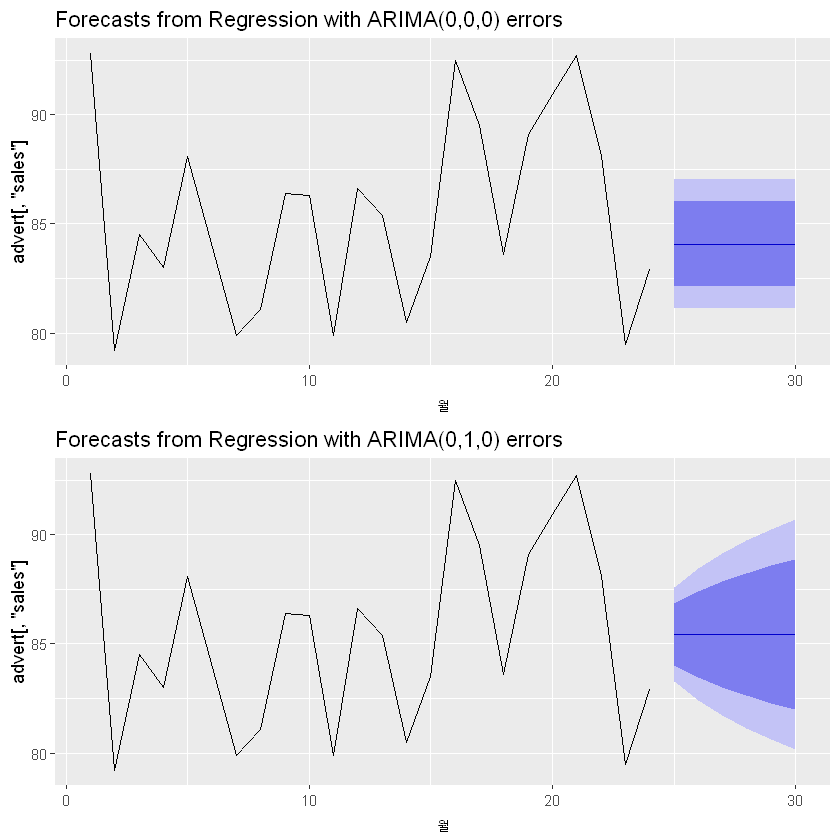

In [86]:
# g.다음 6달에 대해 광고비용이 정확히 1달에 10 단위라고 가정하여, 다음 6달에 대한 판매량 예측값을 예측구간과 함께 얻어봅시다.

# https://otexts.com/fppkr/dynamic-regression-forecasting.html
# rep(10, 6) : 1달에 10 단위, 6 달의 예측값을 계산

p1 <- autoplot(forecast(fit_Arima, xreg = rep(10, 6))) + xlab("월")
p2 <- autoplot(forecast(fit_auto.arima, xreg = rep(10, 6))) + xlab("월")

grid.arrange(p1, p2,
    layout_matrix = rbind(
        c(1),
        c(2)))